# Threshold - per tag score
#### Scan threshold from min to max prediction.
#### Precision, recall and f2 score are calculated per tag, then pick the threshold with highest f2 score per tag.

In [1]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline

import random

In [2]:
import sys
sys.path.append('./utils')

from data import Data
from models import Models
from tags import Tags
tags = Tags()

Using TensorFlow backend.


In [3]:
N_TAGS = 17

def threshold(pred, true):
    # Initialize figure
    fig = plt.figure(figsize=(15,15))
    plt.title('Receiver Operating Characteristic')

    thres = [0] * N_TAGS
    for i in range(N_TAGS):
        print('{}'.format(tags.idx_to_tag(i)))
        thres[i] = tag_threshold(pred[:,i], true[:,i], name=tags.idx_to_tag(i))
        
    # Diagonal 45 degree line
    plt.plot([0,1],[0,1],'k--')

    # Axes limits and labels
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    return thres

def amazon_score(tp, fp, fn):
    p = tp / (tp + fp) if tp + fp > 0 else 0
    r = tp / (tp + fn) if tp + fn > 0 else 0
    result = 5 * p * r / (4 * p + r) if 4 * p + r > 0 else 0
    return result

def tag_threshold(pred, true, name=''):
    pred = pred.reshape((len(pred)))
    true = true.reshape((len(true)))
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(true, pred)
    plt.plot(fpr, tpr, label=name, ls=[ '-' , '--' , '-.' , ':'][random.randint(0, 3)])
    
    N_POS = sum(true)
    N_NEG = len(pred) - N_POS
    pair = list(zip(pred, true))
    pair.sort()
    tp, fp, tn, fn = N_POS, N_NEG, 0, 0
    tag_thres = 0
    max_score = amazon_score(tp, fp, fn)
    best_counts = ()
    for i in range(len(pred)):
        if pair[i][1] == 0:
            fp -= 1
            tn += 1
        else:
            tp -= 1
            fn += 1
        current_score = amazon_score(tp, fp, fn)
        if current_score > max_score:
            max_score = current_score
            tag_thres = pair[i][0]
            best_counts = (tp, fp, tn, fn)
    print('Best (tp, fp, tn, fn) is {}'.format(best_counts))
    print('Best f2 {}'.format(max_score))
    return tag_thres

def calc_threshold(path, toy=None):
    m = Models.load_resnet50(path)
    d = Data(train=[0], toy=toy)
    X, y = d.get_fold(0)
    y_pred = m.predict(X, verbose=1)
    return threshold(y_pred, y)

Loading data...
Getting 20 training images...
Got 1 images
Done
Loaded fold 0.
Loading done
20/20 [==============================] - 10s
haze
Best (tp, fp, tn, fn) is (3.0, 3.0, 14, 0)
Best f2 0.8333333333333334
primary
Best (tp, fp, tn, fn) is ()
Best f2 0.9895833333333334
agriculture
Best (tp, fp, tn, fn) is (6.0, 7.0, 7, 0)
Best f2 0.8108108108108109
clear
Best (tp, fp, tn, fn) is (13.0, 1.0, 6, 0)
Best f2 0.9848484848484849
water
Best (tp, fp, tn, fn) is ()
Best f2 0.7291666666666667
habitation
Best (tp, fp, tn, fn) is ()
Best f2 0
road
Best (tp, fp, tn, fn) is (4.0, 6.0, 10, 0)
Best f2 0.7692307692307692
cultivation
Best (tp, fp, tn, fn) is (1.0, 10.0, 9, 0)
Best f2 0.3333333333333333
slash_burn
Best (tp, fp, tn, fn) is (1.0, 14.0, 5, 0)
Best f2 0.2631578947368421
cloudy
Best (tp, fp, tn, fn) is (1.0, 0.0, 19, 0)
Best f2 1.0
partly_cloudy
Best (tp, fp, tn, fn) is (3.0, 15.0, 2, 0)
Best f2 0.5
conventional_mine
Best (tp, fp, tn, fn) is ()
Best f2 0
bare_ground
Best (tp, fp, tn, fn)

/Users/jiayou/anaconda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


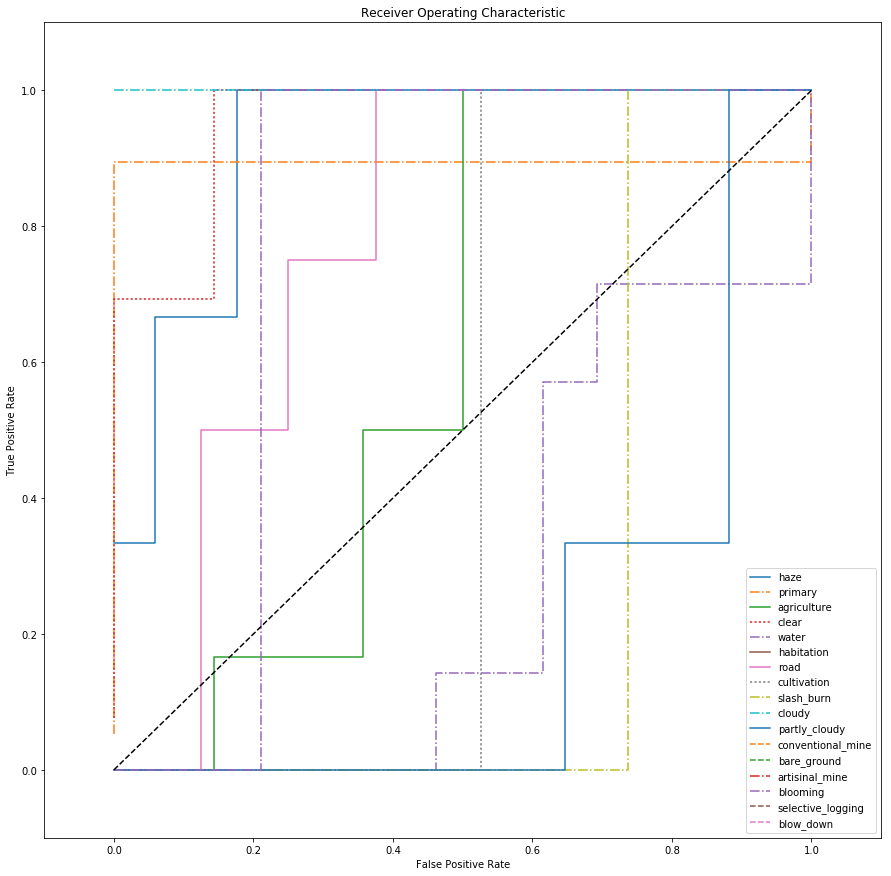

In [4]:
t = calc_threshold('./weights-v9.hdf5', toy=100)

In [5]:
t

[0.64201766,
 0,
 0.1424499,
 0.35644034,
 0,
 0,
 0.19915976,
 0.1871755,
 0.038082417,
 0.035275601,
 0.022560399,
 0,
 0,
 0,
 0.020409012,
 0,
 0]

# Threshold - per image score
#### Scan threshold from 0.1 to 0.3 (100 steps).
#### Precision, recall, and f2 score are calculated per image, then the overall f2 score is the average of all rows.

In [8]:
# print_function for compatibility with Python 3
from __future__ import print_function
print('print function is ready to serve')

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline

# NumPy for numerical computing
import numpy as np
np.random.seed(123)
import random
random.seed(123)

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_column', 100)

import os
import gc
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

print function is ready to serve


In [9]:
import sys
sys.path.append('./utils')

from data import Data
from models import Models
from tags import Tags
tags = Tags()

In [10]:
PLANET_KAGGLE_ROOT = '/data/planet-data/'
if not os.path.exists(PLANET_KAGGLE_ROOT):
    PLANET_KAGGLE_ROOT = '/Users/jiayou/Documents/Kaggle Data/Amazon'

N_TAGS = 17
N_TRAIN = 40479
# N_TRAIN = 10
N_TEST_T = 40669
N_TEST_F = 20522
N_TEST = N_TEST_T + N_TEST_F

In [11]:
from sklearn.metrics import fbeta_score

def amazon_score(tp, fp, fn):
    p = tp / (tp + fp) if tp + fp > 0 else 0
    r = tp / (tp + fn) if tp + fn > 0 else 0
    result = 5 * p * r / (4 * p + r) if 4 * p + r > 0 else 0
    return result

true = tags.y_train(range(N_TRAIN))
best_thres = [[0.21600000000000003,
 0.264,
 0.162,
 0.21800000000000003,
 0.188,
 0.19,
 0.21600000000000003,
 0.20800000000000002,
 0.202,
 0.134,
 0.14600000000000002,
 0.266,
 0.166,
 0.12200000000000001,
 0.17400000000000002,
 0.2,
 0.2]
]
for n in [1,2,4]:
    pred = np.load(os.path.join(PLANET_KAGGLE_ROOT, 'ensemble', 'raw_train_pred.v9.f{}.tta.npy'.format(n)))
    v = [x for x in range(N_TRAIN) if x % 5 == n]
    thres = [0.2] * N_TAGS
    max_score = 0
    current_thres = thres
    for i in range(N_TAGS):
        print('Tag-{}'.format(tags.idx_to_tag(i)))
        for j in range(100):
            if j % 10 == 0:
                print('  thres_{}'.format(0.1 + 0.2 * j / 100.)) 
            current_thres[i] = 0.1 + 0.2 * j / 100.
            current_score = 0
            for k in range(len(v)):
                current_true = true[v[k],:] > 0.5
                current_pred = (pred[v[k],:] > current_thres)
                tp = np.sum(np.logical_and(current_true, current_pred).astype('int'))
                fp = np.sum(np.logical_and(np.logical_not(current_true), current_pred).astype('int'))
                fn = np.sum(np.logical_and(np.logical_not(current_pred), current_true).astype('int'))
                current_score += amazon_score(tp, fp, fn)
            if current_score / len(v) > max_score:
                max_score = current_score / len(v)
                thres = list(current_thres)
                print('{} ({})'.format(max_score, current_thres[i]))
        current_thres[i] = thres[i]
    best_thres.append(list(thres))


Tag-haze
  thres_0.1
0.9174304757531234 (0.1)
0.9174427228616128 (0.10400000000000001)
0.9174834306081715 (0.10600000000000001)
0.9175418281566556 (0.10800000000000001)
0.9176342724735393 (0.11)
0.9176933902698112 (0.112)
0.9177651554502538 (0.114)
0.9178135466177162 (0.116)
0.9178704247486436 (0.11800000000000001)
  thres_0.12000000000000001
0.917872830939291 (0.12000000000000001)
0.917914308179839 (0.12200000000000001)
0.9180245276499275 (0.12400000000000001)
0.9180336760738704 (0.126)
0.918035612428272 (0.128)
0.9181702182324168 (0.13)
0.9182155033658158 (0.132)
0.9183149592459041 (0.134)
0.918346239724319 (0.136)
  thres_0.14
0.9183752681612167 (0.14400000000000002)
0.9183898174215105 (0.14600000000000002)
0.9184057250152343 (0.14800000000000002)
0.9184154708871342 (0.15000000000000002)
0.9184285378391216 (0.15200000000000002)
0.9184634217059813 (0.15400000000000003)
0.9184746505956687 (0.15600000000000003)
0.9184788614293015 (0.15800000000000003)
  thres_0.16
0.9184833475206131 (0

In [12]:
np.mean(np.array(best_thres), axis=0)

array([ 0.205 ,  0.2345,  0.206 ,  0.203 ,  0.189 ,  0.1545,  0.1935,
        0.22  ,  0.222 ,  0.143 ,  0.1335,  0.1775,  0.1845,  0.169 ,
        0.191 ,  0.149 ,  0.1615])

In [13]:
len(v)

8095